# Indoor Semantic Image Segmentation

**Notebook created in PyTorch by [ Xavier Riera, Albert Mestre, José Javier Gómez] for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgraduate-course-artificial-intelligence-deep-learning/) (2020).**



Let's see  gpu we got, ram, etc. 

In [ ]:
 !nvidia-smi

Sun Nov  8 18:59:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inicialization

In [ ]:
#!pip install gdown
#!gdown "https://drive.google.com/uc?id=1pxs-HG4ZehoER60mkz8M4ga2y_NWXmeP"
#!tar -zxf Images-20200929.tar.gz

In [ ]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive/')


#Define inicialization for the random vector. Goal: Reply weights inicialization in diferent executions
import torch
import numpy as np
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Defining the localizations of the files

NAME_EXPERIMENT = 'ModelPretrained'


#DIRECTORY
directory = 'drive/My Drive/Compartida con Albert/'
#directory = 'drive/My Drive/'  

#mypythondirectory
mypythondirectory = directory + 'Google Colabs/Scripts/'


#PATH_IMAGES
PATH_IMG = directory + 'Images/'
#PATH_IMG = '/content/Images/'

#PATH_EXP
PATH_EXP = directory + 'Experiments/'


#Define CSV files path
fparams = {
    
    #Directory definition
    'imagePath': PATH_IMG,
    
    #Define Path to store results of training
    'NAME_EXPERIMENT':  NAME_EXPERIMENT,

    #Define Path to store results of training
    'PATH_EXP': PATH_EXP + NAME_EXPERIMENT + '/', 

    #CSV
    'CSVTrain': 'train.csv',
    'CSVTest': 'test.csv',
    'CSVValidation': 'validation.csv',

    #PATTERNS
    'train': 'train',
    'test': 'test',
    'validation': 'validation',
    'label': 'label',
}

#Importing
import sys
sys.path.append(mypythondirectory)

import utils
import metrics
import models
import datas
import transformations


#Import Image library
from PIL import Image

#Import Tensorboard library
from torch.utils.tensorboard import SummaryWriter

#Import optimizer library
import torch.optim as optim

#Import library to read CSV files
import pandas as pd

#Import library to get images
from skimage import io

#Import library to show images
import matplotlib.pyplot as plt

#Import module named datetime to work with dates and times.
import datetime

#Import tqdm library to display bars
from tqdm.notebook import tqdm as tqdm

#variable to relate identifier-mean of clases
class_name_13 = ['bed', 'books', 'ceiling', 'chair', 'floor', 'furniture', 'objects', 'picture', 'sofa', 'table', 'tv', 'wall', 'window']

#Variable to define colors of classes
color_class_13  = ['#0000FF', '#E95930', '#00DA00', '#9500F0', '#DEF118', '#FFCECE', '#00E0E5', '#6A88CC', '#751D29', '#F023EB', '#00A79C', '#F98B00', '#E1E5C2']

#Construct Loss Function Weights
weights = np.array([2596997, 401145, 1055085, 2621632, 7627296, 11079604, 9694473, 1605117, 1839193, 2317834, 438709, 17795223, 3738536])
weights_if  =  1. / weights
weights_if_sum = weights_if.sum()
weights_if_norm = weights_if/weights_if_sum * 13
weights_if_norm = torch.from_numpy(np.float32(weights_if_norm))


Mounted at /content/drive/


# Dataset transformations

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision

#Define transformation variables

#train  
transform_RGB = transforms.Compose([ 
      #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),                                                          
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

transform_RGB2 = transforms.Compose([                             
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])            

transform_train = transforms.Compose([
        transformations.ToPILImage(),
        transformations.RandomHorizontalFlip(),
        transformations.ResizeAndRandomCrop(300),
        transformations.ToTensor(),
])


#validation
transform_validation = transforms.Compose([
        transformations.ToPILImage(),
        transformations.ResizeAndCenterCrop(300),
        transformations.ToTensor(),
    ])


# Hyperparameters definition

In [ ]:
hparams = {

    #BATCH_SIZE 
    'batch_size': 8, #32,

    #EPOCHS 
    'epochs': 450, #200,

    #LR
    'learning_rate':  1e-3,  #0.001,   

    #MOMENTUM
    'momentum': 0.9,

    #Weight Decay
    'weight_decay': 0.0001,

    #Betas
    'betas': (0.9, 0.999),

    #Dropout
    'dropout' : 0.2,

    #OPTIMIZER
    'optimizer': optim.SGD,    
    
    #DEVICE
    'device':  torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    #Define codification for not classified pixels in a label
    'NOT_CLASSIFIED_VALUE': 255,

}

# Definition of train & val methods


In [ ]:
from collections import defaultdict

def train_epoch(train_loader, network, optimizer, criterion, writer_train, epoch, epochs):

  trainloss = utils.AverageMeter()

  # Activate the train=True flag inside the model
  network.train()
  
  device = hparams['device']
  losses = 0

  iou_epoch = defaultdict(list)
  acc_epoch = []

  train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar

  # For each batch
  for batch_idx, (data, target) in enumerate(train_loop):
      train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch, epochs-1))
    
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      output = network(data)['out']

      loss = criterion(output, torch.squeeze(target))

      #Metrics calculation
      prediction = output.argmax(dim=1).detach().cpu()
      target = target.detach().cpu()
      losses =  loss.detach().cpu().item()
      
      prediction = utils.add255Label(target, prediction)

      iou = metrics.calculate_iou(prediction,target, hparams['NOT_CLASSIFIED_VALUE'])
      for (key, val) in iou.items(): 
        iou_epoch[key].append(val)
      
      acc = metrics.accuracy(prediction,target, hparams['NOT_CLASSIFIED_VALUE'])
      acc_epoch.append(acc)

      acc = metrics.accuracy(prediction,target, hparams['NOT_CLASSIFIED_VALUE'])
      acc_epoch.append(acc)

      loss.backward()
      optimizer.step()

      trainloss.update(losses)

  losses = trainloss.avg
  writer_train.add_scalar('Loss', losses, epoch)
  
  
  return iou_epoch, acc_epoch


def val_epoch(val_loader, network, criterion, writer_val, epoch, epochs):
    # Dectivate the train=True flag inside the model
    network.eval()
    device = hparams['device']

    valLoss = utils.AverageMeter()

    iou_epoch = defaultdict(list)
    acc_epoch = []

    val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loop):
            val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch, epochs-1))

            data, target = data.to(device), target.to(device)
            output = network(data)['out']
            
            val_loss = criterion(output, target).item() # sum up batch loss
            prediction = output.argmax(dim=1).detach().cpu()
            target = target.detach().cpu()


            #Add 255 labels in place where are not labeled
            prediction = utils.add255Label(target, prediction)

            #metrics
            iou = metrics.calculate_iou(prediction,target,hparams['NOT_CLASSIFIED_VALUE'])
            for (key, val) in iou.items(): 
              iou_epoch[key].append(val) 

            acc = metrics.accuracy(prediction,target, hparams['NOT_CLASSIFIED_VALUE'])
            acc_epoch.append(acc)


            if batch_idx == 2:
              img_aux = prediction[0]

            valLoss.update(val_loss)
          
    losses = valLoss.avg

    writer_val.add_scalar('Loss', losses, epoch)
    writer_val.add_image('Evaluation Image example', utils.array_colors_13(img_aux.transpose(1,0)).transpose(2,1,0) ,epoch)


    return iou_epoch, acc_epoch
    
    

# Main

In [ ]:
#Inicialize tensorboards

#1.Step create experiment path
PATH_EXPERIMENT =  fparams['PATH_EXP'] 
PATH_EXPERIMENT_train = PATH_EXPERIMENT + '/train'
PATH_EXPERIMENT_val = PATH_EXPERIMENT + '/val'

In [ ]:
print("%tensorboard --logdir './" + PATH_EXPERIMENT + "'" + " --samples_per_plugin=images=400")

%tensorboard --logdir './drive/My Drive/Compartida con Albert/Experiments/ModelPretrained/' --samples_per_plugin=images=400


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir './drive/My Drive/Compartida con Albert/Experiments/ModelPretrained/' --samples_per_plugin=images=400


In [ ]:
#1

train_data = datas.IndoorDataset(fparams['CSVTrain'], fparams['imagePath'], transform = transform_train, transform_img = transform_RGB)
validation_data = datas.IndoorDataset(fparams['CSVValidation'], fparams['imagePath'], transform = transform_validation, transform_img = transform_RGB2)

train_loader = DataLoader(dataset=train_data, batch_size=hparams['batch_size'], shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=hparams['batch_size'], shuffle=False, num_workers=2)


[DeepLabV3 model with a ResNet-101 backbone (Pytorch Team)](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb#scrollTo=fSIpJK3n2EaM)

In [ ]:
#Create model
#network = models.Unet(dropout = hparams['dropout'])
network = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
network.classifier[-1] = torch.nn.Conv2d(256, 13, 1)


#Put model in GPU
network = network.to(hparams['device'])

#Define CrossEntropy as loss (and ignore 255 labels)
criterion = torch.nn.CrossEntropyLoss(ignore_index = hparams['NOT_CLASSIFIED_VALUE'])                                                   
#criterion = torch.nn.CrossEntropyLoss(ignore_index=hparams['NOT_CLASSIFIED_VALUE'], weight=weights_if_norm.to(hparams['device']))    #Weighted Loss


#Definer Optimizer
#optimizer = hparams['optimizer'](network.parameters(),  hparams['learning_rate'], betas=hparams['betas'], weight_decay=hparams['weight_decay'])         #ADAM
optimizer = hparams['optimizer'](network.parameters(),  hparams['learning_rate'], momentum=hparams['momentum'], weight_decay=hparams['weight_decay'])  #SGD


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0



is best. epoch = 0. IoU = 0.10214912006215775. Pixel Accuracy = 0.43139719251876557.
-------------------------------------------------------------------------------------------------------------------
Summary: 
Best epoch = 0. IoU = 0.10214912006215775. Pixel Accuracy = 0.43139719251876557.


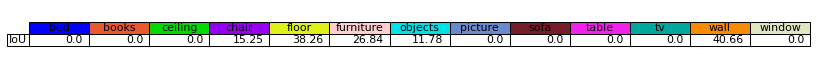

In [ ]:
#2. Create folder path
writer_train = SummaryWriter(PATH_EXPERIMENT_train)
writer_val = SummaryWriter(PATH_EXPERIMENT_val)

epochs = hparams['epochs']

#For truncated to get the first value
for batch_idx, (data, target) in enumerate(validation_loader):
  if batch_idx == 2:
    writer_val.add_image('RGB', data[0], 0)
    writer_val.add_image('GT', utils.array_colors_13(target[0]).transpose(2,1,0).transpose(0,2,1), 0)
  break

best_epoch = 0
best_iou = 0
best_iou_dict = {}
best_epoch_acc = 0

for epoch in range(epochs):

    train_iou_epoch, train_acc_epoch = train_epoch(train_loader, network, optimizer, criterion, writer_train, epoch, epochs)
    validation_iou_epoch, validation_acc_epoch = val_epoch(validation_loader, network, criterion, writer_val, epoch, epochs)

    train_iou_average = metrics.average_complexdict(train_iou_epoch)
    train_acc_average = metrics.average(train_acc_epoch)

    validation_iou_average = metrics.average_complexdict(validation_iou_epoch)
    validation_acc_average = metrics.average(validation_acc_epoch)

    writer_train.add_scalar('mIoU', train_iou_average, epoch)
    writer_train.add_scalar('mAcc', train_acc_average, epoch)
    writer_val.add_scalar('mIoU', validation_iou_average, epoch)
    writer_val.add_scalar('mAcc', validation_acc_average, epoch)

    iou_evolution = metrics.IOUToTensorboard(validation_iou_epoch, train_iou_epoch, class_name_13, color_class_13)
    writer_val.add_image('IOU evolution', iou_evolution ,epoch, dataformats='HWC')

    is_best = validation_iou_average > best_iou
    best_iou = max(validation_iou_average, best_iou)

    utils.save_checkpoint({
        'weights': network.state_dict(),
        'iou': best_iou,
        'iou_dict' :  best_iou_dict,
        'acc' : best_epoch_acc,
        'accuracy_array' : validation_acc_epoch,
        'epoch': best_epoch,
    }, is_best , fparams['PATH_EXP'])

    if is_best :
      best_epoch = epoch
      best_iou_dict = { key : np.array(value).mean() for (key, value) in validation_iou_epoch.items() }
      best_epoch_acc = validation_acc_average

      print("is best. epoch = " + str(best_epoch) + ". IoU = " + str(best_iou) + ". Pixel Accuracy = " + str(best_epoch_acc) + "." )

print("-------------------------------------------------------------------------------------------------------------------")
print("Summary: ")
print("Best epoch = " + str(best_epoch) + ". IoU = " + str(best_iou) + ". Pixel Accuracy = " + str(best_epoch_acc) + "." )
metrics.plot("IoU", best_iou_dict, class_name_13, color_class_13, number_of_classes = 13)

writer_train.flush()
writer_train.close()

writer_val.flush()
writer_val.close()
